# Libraries

In [87]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr

# Data layout

**data**: all of the data needed for the plots is included in the folder **data**.

- **learning**: learning metrics data (acc and accuracy over epochs).

    - **loss**: training and validation loss data.

        - **train**: training loss data.

            - **GregNet.txt**: training loss of GregNet.
            - **GWaveNet.txt**: training loss of GWaveNet.

        - **val**: validation loss data.

            - **GregNet.txt**: validation loss of GregNet.
            - **GWaveNet.txt**: validation loss of GWaveNet.

    - **accuracy**: training and validation accuracy data.

        - **train**: training accuracy data.

            - **GregNet.txt**: training accuracy of GregNet.
            - **GWaveNet.txt**: training accuracy of GWaveNet.

        - **val**: validation accuracy data.

            - **GregNet.txt**: validation accuracy of GregNet.
            - **GWaveNet.txt**: validation accuracy of GWaveNet.

- **flops**

    - **GregNet.txt**: text file with the number of floating point operations and training loss of GregNet.
    - **GWaveNet.txt**: text file with the number of floating point operations and training loss of GWaveNet.

- **probabilities**

    - **GregNet.txt**: text file that includes 3 columns, separated by ": ", in 5 stages, separated by a line with "Folder {i}" where i goes from 0 to 4.
        - *Column 1*: ground truth class.
        - *Column 2*: probability predicted by GregNet.
        - *Column 3*: PISNR of the sample.
    - **GWaveNet.txt**: text file that includes 3 columns, separated by ": ", in 5 stages, separated by a line with "Folder {i}" where i goes from 0 to 4.
        - *Column 1*: ground truth class.
        - *Column 2*: probability predicted by GWaveNet.
        - *Column 3*: PISNR of the sample.

In [99]:
n_folders = 5
n_samples_train = 8000
n_samples_val = 1000

filename_probabilities_GregNet = "data/probabilities/GregNet.txt"
filename_probabilities_GWaveNet = "data/probabilities/GWaveNet.txt"
filename_learning_loss_train_GregNet = "data/learning/loss/train/GregNet.txt"
filename_learning_loss_val_GregNet = "data/learning/loss/val/GregNet.txt"
filename_learning_loss_train_GWaveNet = "data/learning/loss/train/GWaveNet.txt"
filename_learning_loss_val_GWaveNet = "data/learning/loss/val/GWaveNet.txt"
filename_learning_acc_train_GregNet = "data/learning/acc/train/GregNet.txt"
filename_learning_acc_val_GregNet = "data/learning/acc/val/GregNet.txt"
filename_learning_acc_train_GWaveNet = "data/learning/acc/train/GWaveNet.txt"
filename_learning_acc_val_GWaveNet = "data/learning/acc/val/GWaveNet.txt"
filename_flops_GregNet = "data/flops/GregNet.txt"
filename_flops_GWaveNet = "data/flops/GWaveNet.txt"

# Data plots

**Figure 3.3**: Distribution of PISNR of the test subset for each of the data sets:

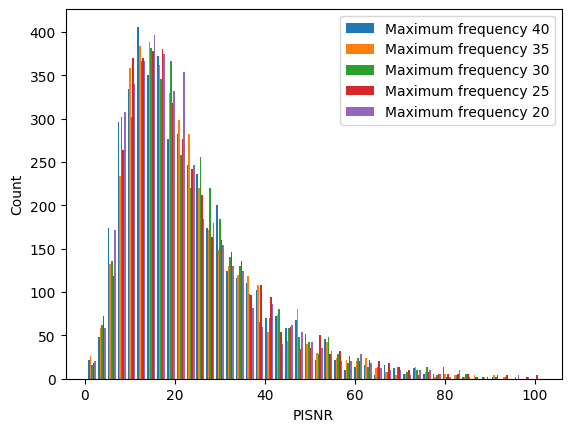

In [100]:
# irrelevant which model is used for this plot, since it only takes the PISNR stats

with open(filename_probabilities_GregNet, "r") as f:
    lines = f.readlines()

pisnr = []
tmp_pisnr = []

for line in lines:
    if "Folder" in line:
        if tmp_pisnr:
            pisnr.append(tmp_pisnr)
            tmp_pisnr = []
    else:
        tmp_pisnr.append(float(line.split(": ")[2]))

pisnr.append(tmp_pisnr)

h = []
n_bins = []

for i in range(len(pisnr)):
    h.append(2 * iqr(pisnr[i]) / (len(pisnr[i]) ** (1 / 3)))
    n_bins.append(int((max(pisnr[i]) - min(pisnr[i])) / h[i]))

plt.hist([pisnr[i] for i in range(len(pisnr))], bins = int(np.mean(n_bins)), label=["Maximum frequency 40", "Maximum frequency 35", "Maximum frequency 30", "Maximum frequency 25", "Maximum frequency 20"])
plt.xlabel("PISNR")
plt.ylabel("Count")
plt.legend(loc="best")
plt.show()

In [101]:
# change here for which model to plot the learning curves
model = "GWaveNet"

**Figure 4.1**: Training and validation losses over number of epochs for (a) GregNet and (b) GWaveNet, with the corresponding 3σ error for each. The burgundy dashed lines signal the end of a curriculum learning stage, with more data from a new data set being added after them. The solid brown short lines signal the best-performing epoch in each stage.

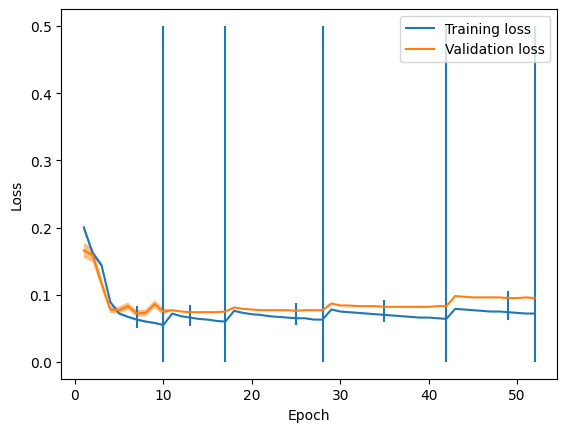

In [102]:
if model == "GregNet":
    filename_learning_loss_train = filename_learning_loss_train_GregNet
    filename_learning_loss_val = filename_learning_loss_val_GregNet
elif model == "GWaveNet":
    filename_learning_loss_train = filename_learning_loss_train_GWaveNet
    filename_learning_loss_val = filename_learning_loss_val_GWaveNet

with open(filename_learning_loss_train, "r") as f:
    lines = f.readlines()

train_loss = []
train_loss_stdev = []
# used to get the number of epochs per curriculum learning stage
n_epochs = []
epoch_counter = 0

for line in lines:
    if "Folder" in line:
        if train_loss:
            n_epochs.append(epoch_counter)
    else:
        train_loss.append(float(line.split(", ")[0][7:-2]))
        train_loss_stdev.append(float(line.split(", ")[1][7:-2]))

        epoch_counter += 1

n_epochs.append(epoch_counter)

for i in range(n_folders):
    if i == 0:
        shaded_loss_train = [3 * x / np.sqrt(n_samples_train * 2 * (i + 1)) for x in train_loss[0:n_epochs[i]]]
    else:
        shaded_loss_train = np.append(shaded_loss_train, [3 * x / np.sqrt(n_samples_train * 2 * (i + 1)) for x in train_loss_stdev[n_epochs[i-1]:n_epochs[i]]])

with open(filename_learning_loss_val, "r") as f:
    lines = f.readlines()

val_loss = []
val_loss_stdev = []
best_epoch = [0, 0, 0, 0, 0]
epoch_counter = 0

for line in lines:
    if "Folder" in line:
        current_folder = int(line.split(" ")[1])
        # epoch_counter = 0
        best_loss = np.inf
    else:
        val_loss.append(float(line.split(", ")[0][7:-2]))
        val_loss_stdev.append(float(line.split(", ")[1][7:-2]))

        if len(val_loss) == 1 or val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            best_epoch[current_folder] = epoch_counter + 1

        epoch_counter += 1

for i in range(n_folders):
    if i == 0:
        shaded_loss_val = [3 * x / np.sqrt(n_samples_val * 2 * (i + 1)) for x in val_loss[0:n_epochs[i]]]
    else:
        shaded_loss_val = np.append(shaded_loss_val, [3 * x / np.sqrt(n_samples_val * 2 * (i + 1)) for x in val_loss_stdev[n_epochs[i-1]:n_epochs[i]]])
    

plt.fill_between(x = np.arange(1, n_epochs[-1] + 1), y1 = [train_loss[i] - shaded_loss_train[i] for i in range(n_epochs[-1])], y2 = [train_loss[i] + shaded_loss_train[i] for i in range(n_epochs[-1])], alpha = 0.5)
plt.fill_between(x = np.arange(1, n_epochs[-1] + 1), y1 = [val_loss[i] - shaded_loss_val[i] for i in range(n_epochs[-1])], y2 = [val_loss[i] + shaded_loss_val[i] for i in range(n_epochs[-1])], alpha = 0.5)
plt.plot(np.arange(1, n_epochs[-1] + 1), train_loss, label="Training loss")
plt.plot(np.arange(1, n_epochs[-1] + 1), val_loss, label="Validation loss")
plt.vlines(x = n_epochs, ymin = 0, ymax = 0.5)
plt.vlines(x = best_epoch, ymin = [min([train_loss[b], val_loss[b]])  - 0.01 for b in best_epoch], ymax = [max([train_loss[b], val_loss[b]]) + 0.01 for b in best_epoch])

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

**Figure 4.2**: Training and validation accuracies over number of epochs for (a) GregNet and (b) GWaveNet, with the corresponding 3σ error for each. The burgundy dashed lines signal the end of a curriculum learning stage, with more data from a new data set being added after them. The solid brown short lines signal the best-performing epoch in each stage.

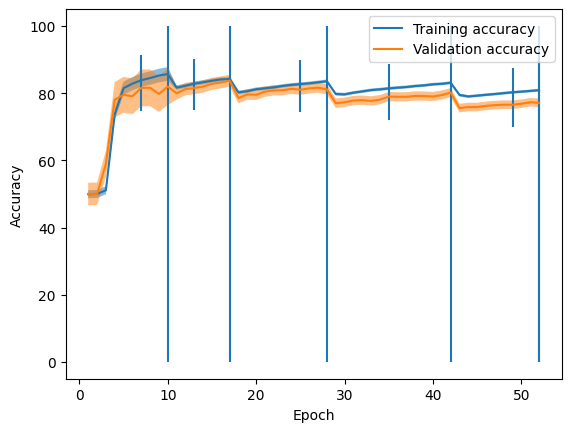

In [103]:
if model == "GregNet":
    filename_learning_acc_train = filename_learning_acc_train_GregNet
    filename_learning_acc_val = filename_learning_acc_val_GregNet
elif model == "GWaveNet":
    filename_learning_acc_train = filename_learning_acc_train_GWaveNet
    filename_learning_acc_val = filename_learning_acc_val_GWaveNet

with open(filename_learning_acc_train, "r") as f:
    lines = f.readlines()

train_acc = []
train_acc_stdev = []

for line in lines:
    if "Folder" in line:
        continue
    else:
        train_acc.append(float(line.split(", ")[0]))
        train_acc_stdev.append(float(line.split(", ")[1]))

n_epochs.append(epoch_counter)

for i in range(n_folders):
    if i == 0:
        shaded_acc_train = [3 * x / np.sqrt(n_samples_train * 2 * (i + 1)) for x in train_acc[0:n_epochs[i]]]
    else:
        shaded_acc_train = np.append(shaded_acc_train, [3 * x / np.sqrt(n_samples_train * 2 * (i + 1)) for x in train_acc_stdev[n_epochs[i-1]:n_epochs[i]]])

with open(filename_learning_acc_val, "r") as f:
    lines = f.readlines()

val_acc = []
val_acc_stdev = []

for line in lines:
    if "Folder" in line:
        continue
    else:
        val_acc.append(float(line.split(", ")[0]))
        val_acc_stdev.append(float(line.split(", ")[1]))

for i in range(n_folders):
    if i == 0:
        shaded_acc_val = [3 * x / np.sqrt(n_samples_val * 2 * (i + 1)) for x in val_acc[0:n_epochs[i]]]
    else:
        shaded_acc_val = np.append(shaded_acc_val, [3 * x / np.sqrt(n_samples_val * 2 * (i + 1)) for x in val_acc_stdev[n_epochs[i-1]:n_epochs[i]]])
    

plt.fill_between(x = np.arange(1, n_epochs[-1] + 1), y1 = [train_acc[i] - shaded_acc_train[i] for i in range(n_epochs[-1])], y2 = [train_acc[i] + shaded_acc_train[i] for i in range(n_epochs[-1])], alpha = 0.5)
plt.fill_between(x = np.arange(1, n_epochs[-1] + 1), y1 = [val_acc[i] - shaded_acc_val[i] for i in range(n_epochs[-1])], y2 = [val_acc[i] + shaded_acc_val[i] for i in range(n_epochs[-1])], alpha = 0.5)
plt.plot(np.arange(1, n_epochs[-1] + 1), train_acc, label="Training accuracy")
plt.plot(np.arange(1, n_epochs[-1] + 1), val_acc, label="Validation accuracy")
plt.vlines(x = n_epochs, ymin = 0, ymax = 100)
plt.vlines(x = best_epoch, ymin = [min([train_acc[b], val_acc[b]]) - 7 for b in best_epoch], ymax = [max([train_acc[b], val_acc[b]]) + 7 for b in best_epoch])

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

**Figure 4.3**: Training losses over number of FLOPs for GregNet (cream) and GWaveNet (orange). We present the average loss per epoch for the cumulative amount of FLOPs and the corresponding 3σ error. The vertical axis is in logarithmic scale.

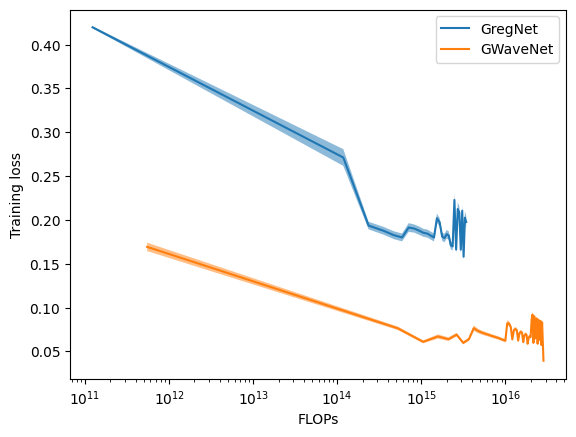

In [104]:
filenames = [filename_flops_GregNet, filename_flops_GWaveNet]
labels = ["GregNet", "GWaveNet"]

for filename in filenames:
    with open(filename, "r") as f:
        lines = f.readlines()

    flops = lines[0].split("], [")[0][1:]
    loss = lines[0].split("], [")[1][:-2]

    flops = flops.split(", ")
    loss = loss.split(", ")

    flops = [float(flop) for flop in flops]
    loss = [float(l) for l in loss]

    # for every 960 data points, save the last flop and average out the loss
    flops_avg = []
    loss_avg = []
    loss_std = []

    for i in range(0, len(flops), 960):
        flops_avg.append(flops[i])
        loss_avg.append(sum(loss[i:i+960])/960)
        loss_std.append(np.std(loss[i:i+960]))

    plt.fill_between(flops_avg, [loss_avg[i] - 3 * loss_std[i]/sqrt(960) for i in range(len(loss_avg))], [loss_avg[i] + 3*loss_std[i]/sqrt(960) for i in range(len(loss_avg))], alpha = 0.5)
    plt.plot(flops_avg, loss_avg, label=labels[filenames.index(filename)])

plt.xlabel("FLOPs")
plt.ylabel("Training loss")
plt.legend(loc="best")
plt.xscale("log")
plt.show()

**Figure 4.4**: Probability distribution for both noise and signal classes for (a) GregNet and (b) GWaveNet.

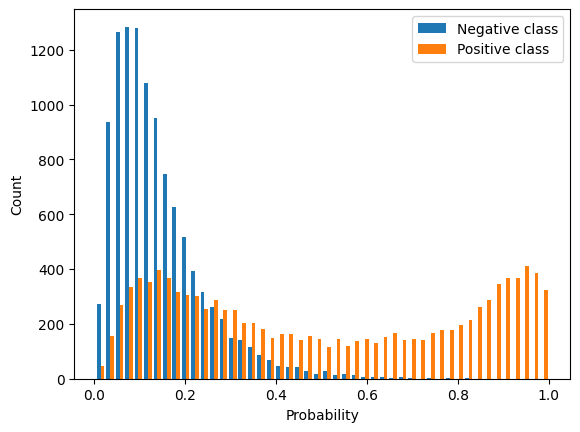

In [105]:
# change here for which model to plot the probabilities for
model = "GWaveNet"

if model == "GregNet":
    filename_probabilities = filename_probabilities_GregNet
elif model == "GWaveNet":
    filename_probabilities = filename_probabilities_GWaveNet

with open(filename_probabilities, "r") as f:
    lines = f.readlines()

negative_class = []
positive_class = []

for line in lines:
    if "Folder" not in line:
        if float(line.split(": ")[0]) == 0:
            negative_class.append(float(line.split(": ")[1]))
        elif float(line.split(": ")[0]) == 1:
            positive_class.append(float(line.split(": ")[1]))

h_negative = 2 * iqr(negative_class) / (len(negative_class) ** (1 / 3))
h_positive = 2 * iqr(positive_class) / (len(positive_class) ** (1 / 3))

n_bins_negative = int((max(negative_class) - min(negative_class)) / h_negative)
n_bins_positive = int((max(positive_class) - min(positive_class)) / h_positive)

plt.hist([negative_class, positive_class], bins = int(np.mean([n_bins_negative, n_bins_positive])), label=["Negative class", "Positive class"])
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend(loc="best")
plt.show()


**Figure 4.7**: FAP over the decision threshold for GregNet (yellow) and GWaveNet (orange). The burgundy dashed line represents the FAP at 1%, and it intercepts the curves at 0.86 and 0.46 respectively.

In [ ]:
filenames = [filename_probabilities_GregNet, filename_probabilities_GWaveNet]

for filename in filenames:
    with open(filename, "r") as f:
        lines = f.readlines()

    for line in lines:
        if "Folder" in line:
            if line.split(" ")[1] != 0:
                true_y.append(tmp_true_y)
                pred_y.append(tmp_pred_y)
                tmp_true_y = []
                tmp_pred_y = []

                # TO FINISH ----------------